<a href="https://colab.research.google.com/github/komorimasashi/HIS2024-GenAI/blob/main/Sentimen_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KaggleにあるAmazon Alexa Reviewsデータセット

https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews




**Amazon Alexa Reviews**

This dataset consists of a nearly 3000 Amazon customer reviews (input text), star ratings, date of review, variant and feedback of various amazon Alexa products like Alexa Echo, Echo dots, Alexa Firesticks etc. for learning how to train Machine for sentiment analysis.
（上記ページから引用）



#### ライブラリの準備とAPIキーの設定

In [1]:
!pip install openai==0.27.0
!pip install -q -U google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.1/70.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.4/725.4 kB 12.4 MB/s eta 0:00:00


In [2]:
import openai
import google.generativeai as genai
from google.colab import userdata

OPENAI_API_KEY=userdata.get('OPENAI_API_KEY')
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

In [3]:
import pandas as pd
import openai
import re
import json
import time
from sklearn.metrics import confusion_matrix, accuracy_score

#### データセット

In [5]:
# データの読み込み
data = pd.read_csv('amazon_alexa.tsv', sep='\t')
data.head(10)

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [6]:
# レビューと正解ラベルの抽出
review_data = data[['verified_reviews','feedback']]
review_data.columns = ['review','label']
review_data.head()

,review,label
0,Love my Echo!,1
1,Loved it!,1
2,"Sometimes while playing a game, you can answer...",1
3,I have had a lot of fun with this thing. My 4 ...,1
4,Music,1


In [7]:
# ラベルごとのサンプルのサイズ
label_counts = review_data["label"].value_counts()
label_counts

,count
label,
1,2893
0,257


In [8]:
# ラベルの数を均等にする
# ラベルのカウント
label_counts = review_data["label"].value_counts()

# ラベルの数の差を計算
rows_to_drop = label_counts.max() - label_counts.min()

# ラベルが異なる行をランダムに削除
if rows_to_drop > 0:
   data_majority = review_data[review_data["label"] == 1]
   data_balanced = review_data.drop(data_majority.sample(rows_to_drop).index)
else:
   data_balanced = review_data.copy()

# 確認
data_balanced["label"].value_counts()

# 20件を抽出する
test_set = data_balanced.sample(20)

#### データの前処理

In [9]:
def clean_text(text):
    #特殊文字や句読点を削除
    text = re.sub(r"[^\w\s]", " ", text)

    #単一文字を削除
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)

    #HTMLタグを削除
    text = re.sub(r"<[^>]*>", " ", text)

    #テキストを小文字化
    text = text.lower()

    #余分な空白を削除
    text = re.sub(r"\s+", " ", text)

    #先頭と末尾の空白を削除
    text = text.strip()

    text = re.sub(r'\u3000', '', text)
    text = re.sub(r"^\('(.+?)',\)$", r'\1', text)

    return text

In [10]:
# reviewの列を前処理
reviews = test_set['review'].tolist()
cleaned_reviews = [clean_text(str(review)) if pd.notna(review) else '' for review in reviews]
test_set['clean_reviews'] = cleaned_reviews

#### Geminiによるセンチメント分析

In [11]:
genai.configure(api_key=GOOGLE_API_KEY)

for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

model = genai.GenerativeModel('gemini-pro')

models/gemini-1.0-pro-latest
models/gemini-1.0-pro
models/gemini-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro
models/gemini-1.5-pro-exp-0801
models/gemini-1.5-pro-exp-0827
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-exp-0827
models/gemini-1.5-flash-8b-exp-0827


In [12]:
test_set_gemini = test_set
test_set_gemini['pred_label'] = ''
test_set_gemini

,review,label,clean_reviews,pred_label
1352,"The product is attractive and somewhat useful,...",0,the product is attractive and somewhat useful ...,
1851,I bought this specifically for the smart hub c...,1,bought this specifically for the smart hub cap...,
653,I wanted a white dot for my white bathroom. T...,0,wanted white dot for my white bathroom the top...,
400,Love it. Beautiful experience especially if ho...,1,love it beautiful experience especially if hoo...,
1252,This product is a complete waste of money. Whe...,0,this product is complete waste of money when y...,
2519,I love it,1,love it,
1495,Love it! Great to request music and be able t...,1,love it great to request music and be able to ...,
2266,I like my Amazon Fire stick I use it for my TV...,1,like my amazon fire stick use it for my tv tha...,
2418,Purchased to use on the road in my semi. Does ...,0,purchased to use on the road in my semi does n...,
1933,Works as advertised! It says Alexa is always l...,1,works as advertised it says alexa is always le...,


In [13]:
# DataFrame を JSON に変換する
json_data = test_set_gemini[['clean_reviews','pred_label']].to_json(orient='records')

# JSON データを表示
print(json_data)

[{"clean_reviews":"the product is attractive and somewhat useful but amazon chose to force users to view their things to try and trending this greatly depreciates the value of the product do not buy unless you are willing to view billboard from amazon","pred_label":""},{"clean_reviews":"bought this specifically for the smart hub capability so far it has been great easy set up instructions for all the various brands compatible with it","pred_label":""},{"clean_reviews":"wanted white dot for my white bathroom the top is black as shown which knew but did not realize the cord and plug were also black wanted white cord and plug","pred_label":""},{"clean_reviews":"love it beautiful experience especially if hooked to smart lighting and other accessories","pred_label":""},{"clean_reviews":"this product is complete waste of money when you ask alexa question she either doesn know the answer gives you the wrong answer or finds information off of wikipedia","pred_label":""},{"clean_reviews":"love 

In [14]:
prompt = f"""
You are  a marketing expert who is good at classifying customer review sentiments into Positive/Negative labels.
Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
Customer reviews are provided between three back ticks.
In your output, only return the Json code back as output - which is provided between three backticks.
Your task is to update predicted labels under 'pred_label' in the Json code.
Don't make any changes to Json code format, please.

```
{json_data}
```
"""

In [16]:
response = model.generate_content(prompt)

print(response.text)

import json

# バッククォートを削除してデータをクリーンにする
json_data = response.text.strip("`")

# データを読み込み、DataFrameに変換する
data = json.loads(json_data)
df_sample = pd.DataFrame(data)

df_sample

# 'df'のpred_labelを'pred_label'に上書きして'train_set_sample'に反映する

test_set_gemini['pred_label'] = df_sample['pred_label'].values
test_set_gemini

```
[{"clean_reviews":"the product is attractive and somewhat useful but amazon chose to force users to view their things to try and trending this greatly depreciates the value of the product do not buy unless you are willing to view billboard from amazon","pred_label":0},{"clean_reviews":"bought this specifically for the smart hub capability so far it has been great easy set up instructions for all the various brands compatible with it","pred_label":1},{"clean_reviews":"wanted white dot for my white bathroom the top is black as shown which knew but did not realize the cord and plug were also black wanted white cord and plug","pred_label":0},{"clean_reviews":"love it beautiful experience especially if hooked to smart lighting and other accessories","pred_label":1},{"clean_reviews":"this product is complete waste of money when you ask alexa question she either don know the answer gives you the wrong answer or finds information off of wikipedia","pred_label":0},{"clean_reviews":"love it"

,review,label,clean_reviews,pred_label
1352,"The product is attractive and somewhat useful,...",0,the product is attractive and somewhat useful ...,0
1851,I bought this specifically for the smart hub c...,1,bought this specifically for the smart hub cap...,1
653,I wanted a white dot for my white bathroom. T...,0,wanted white dot for my white bathroom the top...,0
400,Love it. Beautiful experience especially if ho...,1,love it beautiful experience especially if hoo...,1
1252,This product is a complete waste of money. Whe...,0,this product is complete waste of money when y...,0
2519,I love it,1,love it,1
1495,Love it! Great to request music and be able t...,1,love it great to request music and be able to ...,1
2266,I like my Amazon Fire stick I use it for my TV...,1,like my amazon fire stick use it for my tv tha...,1
2418,Purchased to use on the road in my semi. Does ...,0,purchased to use on the road in my semi does n...,0
1933,Works as advertised! It says Alexa is always l...,1,works as advertised it says alexa is always le...,1


In [17]:
#混同行列の可視化
from sklearn.metrics import confusion_matrix

y_true = test_set_gemini["label"]
y_pred = test_set_gemini["pred_label"]

confusion_matrix(y_true, y_pred)

array([[ 9,  0],
       [ 1, 10]])

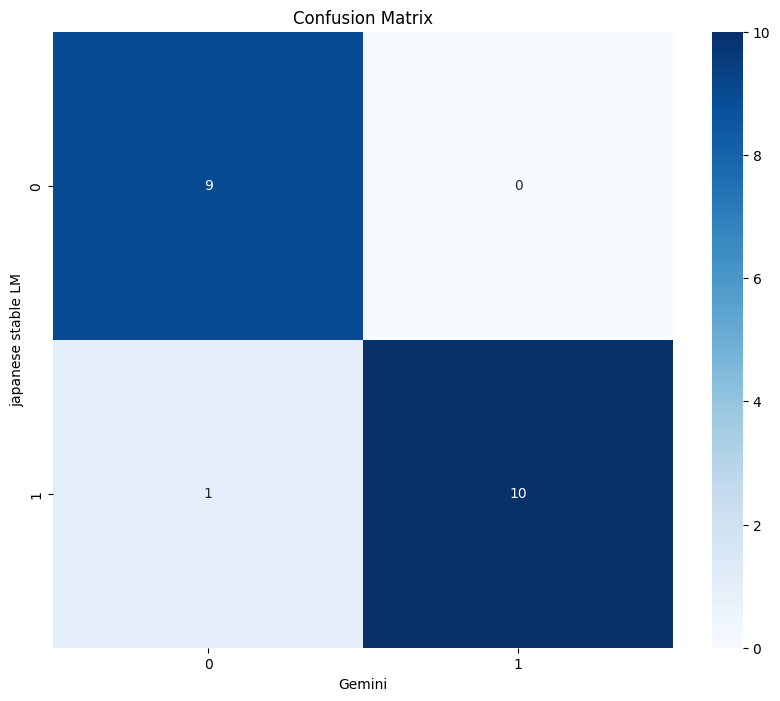

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_true))
plt.xlabel('Gemini')
plt.ylabel('japanese stable LM')
plt.title('Confusion Matrix')
plt.show()

#### ChatGPTによるセンチメント分析

In [19]:
# GPT_MODEL = "gpt-3.5-turbo"
GPT_MODEL = "gpt-4o-mini-2024-07-18"

In [20]:
def get_completion(prompt, model=GPT_MODEL):

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)

  return response.choices[0].message["content"]

In [21]:
test_set_gpt = test_set
test_set_gpt['pred_label'] = ''
test_set_gpt

,review,label,clean_reviews,pred_label
1352,"The product is attractive and somewhat useful,...",0,the product is attractive and somewhat useful ...,
1851,I bought this specifically for the smart hub c...,1,bought this specifically for the smart hub cap...,
653,I wanted a white dot for my white bathroom. T...,0,wanted white dot for my white bathroom the top...,
400,Love it. Beautiful experience especially if ho...,1,love it beautiful experience especially if hoo...,
1252,This product is a complete waste of money. Whe...,0,this product is complete waste of money when y...,
2519,I love it,1,love it,
1495,Love it! Great to request music and be able t...,1,love it great to request music and be able to ...,
2266,I like my Amazon Fire stick I use it for my TV...,1,like my amazon fire stick use it for my tv tha...,
2418,Purchased to use on the road in my semi. Does ...,0,purchased to use on the road in my semi does n...,
1933,Works as advertised! It says Alexa is always l...,1,works as advertised it says alexa is always le...,


In [22]:
batches = []
batch_size = 50

for i in range(0, len(test_set_gpt), batch_size):
  batches.append(test_set_gpt[i : i + batch_size])

In [23]:
openai.api_key  = OPENAI_API_KEY
model = GPT_MODEL

def get_completion(prompt, model="gpt-3.5-turbo"):

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)

  return response.choices[0].message["content"]

In [24]:
import time

def gpt_completion_function(batch,current_batch,total_batch,model="gpt-3.5-turbo-1106"):
  """Function works in three steps:
  # Step-1: Convert the DataFrame to JSON using the to_json() method.
  # Step-2: Preparing the Gemini Prompt
  # Step-3: Calling GPT API
  """

  print(f"Now processing batch#: {current_batch+1} of {total_batch}")

  json_data = batch[['clean_reviews','pred_label']].to_json(orient='records')

  prompt = f"""You are a marketing expert, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  {json_data}
  ```
  """

  print(prompt)

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)
  time.sleep(5)
  return response.choices[0].message["content"]

In [25]:
batch_count = len(batches)
responses = []

for i in range(0,len(batches)):
  responses.append(gpt_completion_function(batches[i],i,batch_count))

Now processing batch#: 1 of 1
You are a marketing expert, who is good at classifying customer review sentiments into Positive/Negative labels.
  Help me classify customer reviews into: Positive(label=1), and Negative(label=0).
  Customer reviews are provided between three backticks below.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  [{"clean_reviews":"the product is attractive and somewhat useful but amazon chose to force users to view their things to try and trending this greatly depreciates the value of the product do not buy unless you are willing to view billboard from amazon","pred_label":""},{"clean_reviews":"bought this specifically for the smart hu

In [26]:
import json
import pandas as pd


df_gpt= pd.DataFrame()  # Initialize an empty DataFrame

for response in responses:
  # Clean the data by stripping the backticks
  json_data = response.strip("`")

  # Load the cleaned data and convert to DataFrame
  data = json.loads(json_data)
  df_temp = pd.DataFrame(data)

  # Append the DataFrame to the final DataFrame
  df_gpt = pd.concat([df_gpt, df_temp], ignore_index=True)

test_set_gpt['pred_label'] =  df_gpt['pred_label'].values
test_set_gpt

,review,label,clean_reviews,pred_label
1352,"The product is attractive and somewhat useful,...",0,the product is attractive and somewhat useful ...,0
1851,I bought this specifically for the smart hub c...,1,bought this specifically for the smart hub cap...,1
653,I wanted a white dot for my white bathroom. T...,0,wanted white dot for my white bathroom the top...,0
400,Love it. Beautiful experience especially if ho...,1,love it beautiful experience especially if hoo...,1
1252,This product is a complete waste of money. Whe...,0,this product is complete waste of money when y...,0
2519,I love it,1,love it,1
1495,Love it! Great to request music and be able t...,1,love it great to request music and be able to ...,1
2266,I like my Amazon Fire stick I use it for my TV...,1,like my amazon fire stick use it for my tv tha...,1
2418,Purchased to use on the road in my semi. Does ...,0,purchased to use on the road in my semi does n...,0
1933,Works as advertised! It says Alexa is always l...,1,works as advertised it says alexa is always le...,1


In [27]:
y_true = test_set_gpt["label"]
y_pred = test_set_gpt["pred_label"]


#混同行列
conf_matrix=confusion_matrix(y_true, y_pred)
print(confusion_matrix(y_true, y_pred))
print(f"\nAccuracy: {accuracy_score(y_true, y_pred)}")

[[ 9  0]
 [ 1 10]]

Accuracy: 0.95


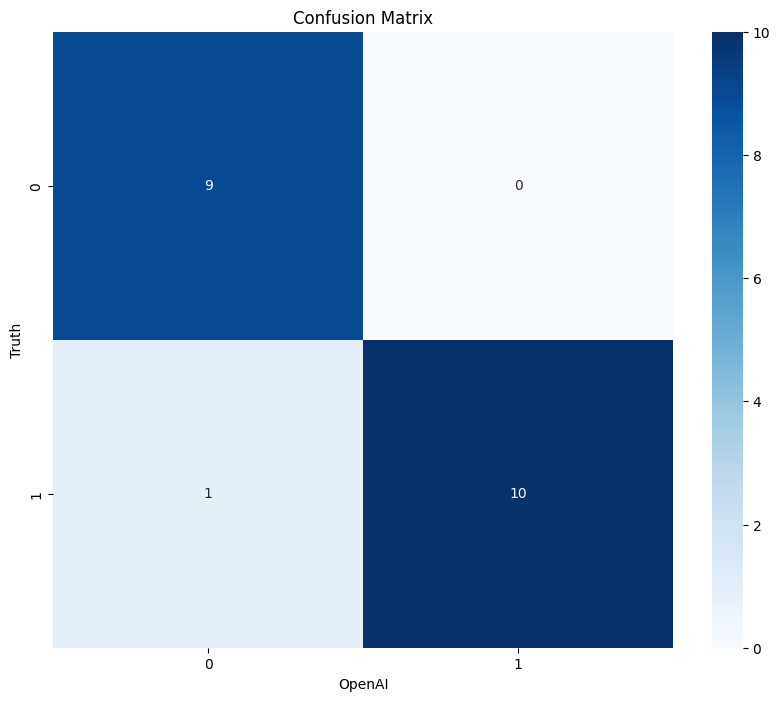

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_true))
plt.xlabel('OpenAI')
plt.ylabel('Truth')
plt.title('Confusion Matrix')
plt.show()